# Basic Example of Tent Functions

This is a demonstration of how to use tent functions on a set of persistence diagrams. Shows you how to set up the parameters, partition the diagram, build the matrix representing the feature vector for each diagram, and visualize how the tent functions work and the output.

In [1]:
import numpy as np

from teaspoon.ML.Base import ParameterBucket, build_G, TentParameters
from scipy import stats
import matplotlib.pyplot as plt

import pandas as pd

## Make Persistence Diagrams

- Make a fake set of diagrams with one point per diagram. 
- Convert to a pd.Series in Birth Death coordinates. 
- Plot diagrams on top of each other.

This could be replaced with any other random set of PDs, just a simple example for error checking.

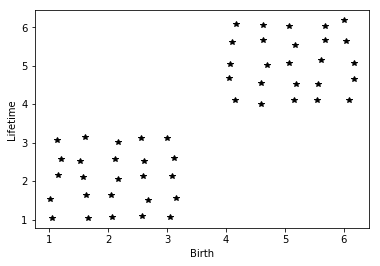

In [2]:
# Make fake dgms 
Dgms = []
np.random.seed(48824)

x = np.linspace(1,3,num=5)
y = np.copy(x)
for i in x:
    for j in y:
        Dgms.append([i,j] + 0.2*np.random.rand(2))
x = np.linspace(4,6,num=5)
y = np.copy(x)
for i in x:
    for j in y:
        Dgms.append([i,j] + 0.2*np.random.rand(2))
Dgms = np.array(Dgms)

#birth lifetime
x = Dgms[:,0]
y = Dgms[:,1]

numDgms = len(Dgms)
columns = ['Dgm1']
index = range(numDgms)
DgmsDF = pd.DataFrame(columns = columns, index = index)

# this is in birth death! 
for i in range(len(Dgms)):
    DgmsDF.loc[i] = [np.array([[x[i], y[i] + x[i]]])]
DgmsDF = pd.Series(data=DgmsDF['Dgm1'])

plt.plot(Dgms[:,0], Dgms[:,1],'k*')
plt.xlabel('Birth')
plt.ylabel('Lifetime')
plt.show()

## Set up Parameters for Tents

 - Need a TentParameters parameter bucket. 
 - Set parameter d for mesh size in each direction.
 - Get adaptive partitions. 
 - Set delta and epsilon for each partition.
 
 If you don't want to use adaptive partitions, switch the boolean *params.useAdaptivePart* to *False*.

In [5]:
params = TentParameters()
params.d = [3,3]
params.useAdaptivePart = True

if params.useAdaptivePart == True:
    # Hand the series to the makeAdaptivePartition function
    params.makeAdaptivePartition(DgmsDF, meshingScheme = 'DV', numParts = 2)
else:
    # Just use the bounding box as the partition
    params.makeAdaptivePartition(DgmsDF, meshingScheme = 'None')

# Assign delta and epsilon for each partition
# If you didn't use adaptive partitioning this just assigns it to the one partition for the whole bounding box
params.chooseDeltaEpsForPartitions()

Converting the data to ordinal...

Parameters d, delta and epsilon have all been assigned to each partition...



## Build Feature Matrix and Plot it
- Each row corresponds to a single diagram
- Each column represents a single tent function
- W/out Adaptive Partitioning: \# Cols = $(d+1)\times(d+1)$
- With  Adaptive Partitioning: \# Cols = $(d+1)\times(d+1)\times$(Num of Partitions) 

Note: *build_G* assumes pd.Series of persistence diagrams is in BirthDeath Coordinates.

To visualize G, uncomment the plotting commands below.

In [6]:
#Build G matrix
G = build_G(DgmsDF, params)

# # Plot G
# G_plot = plt.pcolor(G)
# cbar = plt.colorbar(G_plot)
# cbar.set_clim(0, 1.0)
# plt.show()

## Visualize Tent Centers

To see how all of this works, let's plot: 
- all diagram points (black stars), 
- partition boundaries (black lines),
- the boundary of the support of all the tent functions (blue dashed lines),
- points where tents are centered (solid dots, different colors correspond to centers within a partition)

Important notes:
- Support may not be centered around the partition box 
 - if with the parameters the support is going to cross the horizontal axis, then the support is shifted up so the bottom of the box lies along the axis
- Centers of tents may not be contained in the partition
 - delta parameter is calculated to be max(width/d , height/d) (or max(width/dx , height/dy) if d = [dx, dy]) so it ensures it covers the entire partition but this also means it may extend outside the partition 
 - this is fine, the tents within a partition will not be evaluated on points that are not contained in the partition 

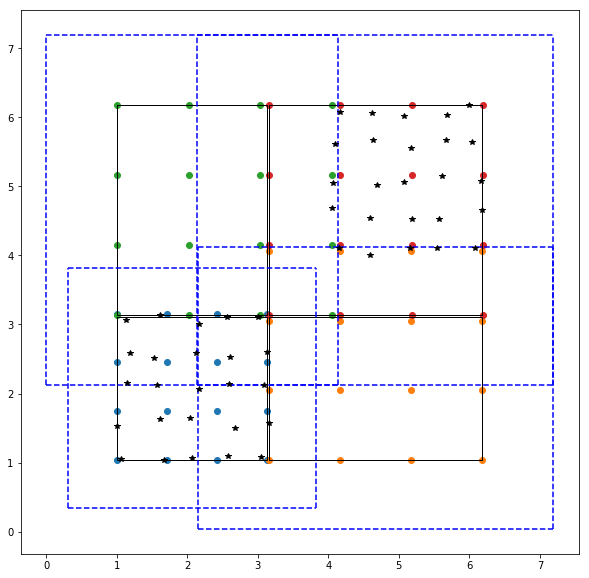

In [7]:
# Calculate tent centers based on d, delta, epsilon
tent_centers = params.calcTentCenters()

# Plot partitions and overlay the data
plt.rcParams['figure.figsize'] = [10, 10]
params.partitions.plot()
plt.plot(x, y, 'k*')
for centers in tent_centers:
    plt.scatter(centers[:,0], centers[:,1])

params.plotTentSupport()

plt.show()

### For a full example of using the tent function for a machine learning experiment see the Jupyter Notebook MLTentExample.ipynb